In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torchvision
from torch.nn import functional as F
from torch import nn
import torch.optim as optim

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [3]:
#torch.utils.data.DataLoader()

In [4]:
!ls files/MNIST/processed/

test.pt  training.pt


In [5]:
# make a transformation in the dataset images
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

dataset_train = torchvision.datasets.MNIST('files/', train=True, download=True, transform=transform)
dataset_test = torchvision.datasets.MNIST('files/', train=False, download=True, transform=transform)




In [6]:
print(dataset_train.data.shape)
print(dataset_test.data.shape)
batch_size_train = 32
batch_size_train = 32

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True)

In [8]:
class Genereator(nn.Module):
    
    def __init__(self):
        super(Genereator, self).__init__()
        
        output_dense1 = 10 * 10 * 256
        self.dense1 = nn.Linear(100, output_dense1)
        self.batch_norm1 = nn.BatchNorm1d(output_dense1)
        
        #output = (input - 1)*stride + kernel
        #output = (7 - 1)*1 + 5 = 7
        self.conv1 = nn.ConvTranspose2d(256,128, kernel_size=(5,5), stride=(1,1), padding=1, bias=False)
                     
        self.batch_norm2 = nn.BatchNorm2d(128)
        
        #output = (input - 1)*stride + kernel
        #output = (10.75 -5)*2 + 5 = 14
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=(5,5), stride=(1,1), padding=1,bias=False)
        self.batch_norm3 = nn.BatchNorm2d(64)
        
        # output = (input - kernel)*stride - 2*padding + dilat*(kernel-1) + out_padding + 1
        # output = (input - 1)*stride + kernel 
        #output = (16.5-5)*2 + 5 = 28
        self.conv3 = nn.ConvTranspose2d(64,1, kernel_size=(4,4), stride=(2,2), padding=1, bias=False)        
        self.batch_norm4 = nn.BatchNorm2d(1)
        
        
    def forward(self,x):
            
        x = self.dense1(x)
        x = F.leaky_relu(self.batch_norm1(x))
        
        x = x.reshape((-1, 256, 10,10))       
        
        x = self.conv1(x)
        x = F.leaky_relu(self.batch_norm2(x)) 
        
        x = self.conv2(x)
        x = F.leaky_relu(self.batch_norm3(x))   
        
        x = self.conv3(x)
        x = F.tanh(self.batch_norm4(x))  
        x = torch.squeeze(x,1)
        
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, dim_x, dim_y):
        super(Discriminator, self).__init__()        
        
        #out_dim = (input_dim - kernel_size)/stride + 1 = (28 - 3)/2 + 1 = ~= 14
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(2,2), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        #out_put_dim = (14 - 3)/2 + 1 ~= 7
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.input_dim = 128 * 6 * 6
        self.dense = nn.Linear(self.input_dim, 1)
        
        
    def forward(self, x):
        
        x = torch.unsqueeze(x,1)
        x = self.conv1(x)
        x = F.leaky_relu(self.bn1(x))
        
        x = self.conv2(x)
        x = F.leaky_relu(self.bn2(x))
        
        x = x.reshape(-1, self.input_dim)
        
        x = self.dense(x)
        
        return x

In [10]:
gen_model = Genereator()
noise = torch.randn([32,100])
gen_image = gen_model(noise).data.numpy()
print(gen_image.shape)

(32, 28, 28)


/home/randson/.local/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [11]:
img = np.squeeze(gen_image[0])

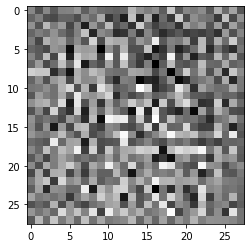

In [12]:
plt.imshow(img, cmap='gray')

In [13]:
discr_model = Discriminator(28,28)
print(discr_model)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense): Linear(in_features=4608, out_features=1, bias=True)
)


In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = F.mse_loss(torch.ones_like(real_output), real_output)
    fake_loss = F.mse_loss(torch.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss    
    return total_loss
    
def generator_loss(fake_output):
    loss = F.mse_loss(torch.ones_like(fake_output), fake_output)
    return loss
    

In [15]:
noise = torch.randn([32,100])
gen_image = gen_model(noise)
pred = discr_model(gen_image)

In [16]:
EPOCHS = 15
noise_dim = 100
num_examples_to_generate = 16

In [17]:
noise = torch.rand(num_examples_to_generate, noise_dim)

In [18]:
X_train, y_train = dataset_train.data, dataset_train.targets
X_test, y_test = dataset_test.data, dataset_test.targets

print(X_train.shape)
print(X_test.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [20]:
gen_opt = optim.Adam(gen_model.parameters(), lr=1e-3)
discr_opt = optim.Adam(discr_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    
    generated_images = gen_model(noise)
    
    real_output = discr_model(X_train.type(torch.float32))
    fake_output = discr_model(generated_images)
    
    gen_loss = generator_loss(fake_output)
    discr_loss = discriminator_loss(real_output, fake_output)
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    
    discr_opt.zero_grad()
    discr_loss.backward()
    discr_opt.step() 
    
    print("{} from {}\tloss gen: {.:4f}\tloss disc: {.:4f}".format(epoch, EPOCHS), end="", flush=True)
    

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0
